### Install required libraries

In [1]:
!pip install -q gdown patool numpy pandas matplotlib torch torchvision timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import gdown
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from timm.loss import LabelSmoothingCrossEntropy # Better than nn.CrossEntropyLoss

%matplotlib inline

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Download training and validation data from Google Drive

In [3]:
file_id = "1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL"
file_name = "Project_data.zip"
gdown.download(f"https://drive.google.com/uc?id={file_id}", file_name)

Downloading...
From (original): https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL
From (redirected): https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL&confirm=t&uuid=7d965d69-5317-42e9-a903-c617c378db71
To: /content/Project_data.zip
100%|██████████| 1.71G/1.71G [00:17<00:00, 95.7MB/s]


'Project_data.zip'

In [4]:
# Remove extracted files if already exist
!rm -rf 'Project_data'
# Unzip file
!unzip -qq Project_data.zip

In [5]:
data_root_dir = "/content/Project_data"
train_images_dir = os.path.join(data_root_dir, 'train')
val_images_dir = os.path.join(data_root_dir, 'val')
train_csv_file = os.path.join(data_root_dir, 'train.csv')
val_csv_file = os.path.join(data_root_dir, 'val.csv')

In [6]:
train_data_df = pd.read_csv(train_csv_file)
df = pd.DataFrame(train_data_df.iloc[:, 0].str.split(';').tolist(), columns = ['folder', 'label','class'])
classes = df['class'].unique()

In [7]:
# Hyperparameters
num_epochs = 1
batch_size = 2
learning_rate = 0.001

In [8]:
class CustomVideoDataset(Dataset):

  def __init__(self, images_dir, data_file, transform):

    self.images_dir = images_dir
    self.transform = transform
    data_df = pd.read_csv(data_file)
    self.data = data_df.iloc[:, 0].str.split(';')

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    images = []
    images_path = os.path.join(self.images_dir, self.data[index][0])
    # print(f'Loading video images from folder {images_path}')
    for image_file in os.scandir(images_path):
      image = Image.open(os.path.join(images_path, image_file))
      if self.transform:
        image = self.transform(image)
      images.append(image)

    label = self.data[index][2]

    images = torch.stack(images)
    labels = torch.tensor(int(label), dtype=torch.long)

    return images, labels


In [9]:
transform = transforms.Compose([
  transforms.Resize(224),
  transforms.ToTensor(),
  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

train_dataset = CustomVideoDataset(train_images_dir, train_csv_file, transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

val_dataset = CustomVideoDataset(val_images_dir, val_csv_file, transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

In [10]:
def inverse_normalize(tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    mean = torch.as_tensor(mean, dtype=tensor.dtype, device=tensor.device)
    std = torch.as_tensor(std, dtype=tensor.dtype, device=tensor.device)
    if mean.ndim == 1:
        mean = mean.view(-1, 1, 1)
    if std.ndim == 1:
        std = std.view(-1, 1, 1)
    tensor.mul_(std).add_(mean)
    return tensor

Train images shape: torch.Size([2, 30, 3, 224, 298])


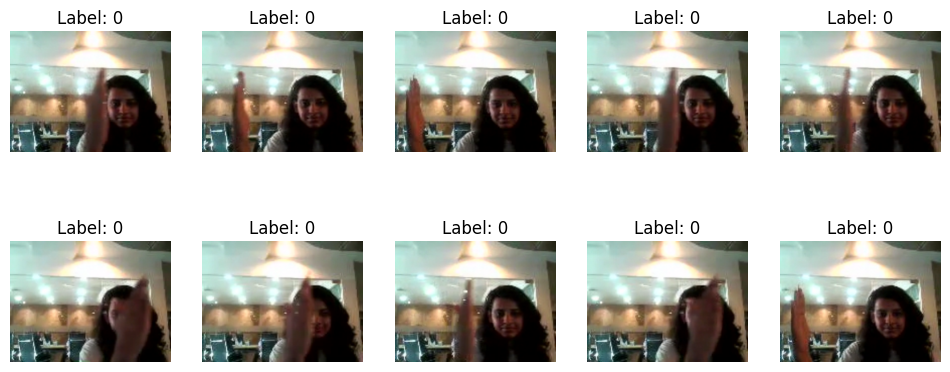

In [12]:
batch_of_video_image_frames, labels = next(iter(train_loader))
print(f'Train images shape: {batch_of_video_image_frames.shape}')

_, axs = plt.subplots(2, 5, figsize=(12, 5))

index = 0
for row in range(2):
  for col in range(5):
    input_tensor= inverse_normalize(tensor=batch_of_video_image_frames[0][index])
    img = input_tensor.squeeze(0)
    axs[row, col].imshow(transforms.ToPILImage()(img))
    axs[row, col].set_title('Label: ' + str(labels[0].item()))
    axs[row, col].axis('off')
    index += 1

In [13]:
class CNNLSTM(nn.Module):
    def __init__(self, num_classes=5):
        super(CNNLSTM, self).__init__()
        self.resnet = models.resnet101(pretrained=True)
        self.resnet.fc = nn.Sequential(nn.Linear(self.resnet.fc.in_features, 300))
        self.lstm = nn.LSTM(input_size=300, hidden_size=256, num_layers=3)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x_3d):
        hidden = None

        # Iterate over each frame of a video in a video of batch * frames * channels * height * width
        for t in range(x_3d.size(1)):
            with torch.no_grad():
                x = self.resnet(x_3d[:, t])
            # Pass latent representation of frame through lstm and update hidden state
            out, hidden = self.lstm(x.unsqueeze(0), hidden)

        # Get the last hidden state (hidden is a tuple with both hidden and cell state in it)
        x = self.fc1(hidden[0][-1])
        x = F.relu(x)
        x = self.fc2(x)

        return x

In [14]:
model = CNNLSTM()
model.to(device)

criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:02<00:00, 75.0MB/s]


In [18]:
for epoch in range(num_epochs):
  model.train()

  running_loss = 0.0
  running_corrects = 0
  running_total = 0

  with tqdm(train_loader, unit="batch", total=len(train_loader)) as tepoch:
    for i, (inputs, labels) in enumerate(tepoch):
      tepoch.set_description(f"Epoch {epoch}")

      optimizer.zero_grad()

      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      loss = criterion(outputs, labels)

      predictions = outputs.argmax(dim=1, keepdim=True)
      print(f'predictions: {predictions}')
      print(f'(predictions == labels): {(predictions == labels)}')
      corrects = (predictions == labels).sum().item()
      print(f'corrects: {corrects}')
      print(f'inputs.size(0): {inputs.size(0)}')
      accuracy = corrects / inputs.size(0)

      running_loss += loss.item() * inputs.size(0)
      running_total += labels.size(0)
      running_corrects += corrects

      loss.backward()
      optimizer.step()

      tepoch.set_postfix(loss=loss.item(), accuracy=100. * accuracy)

      print(f'running_total: {running_total}; running_loss: {running_loss}; running_corrects: {running_corrects}')

  # Calculate the training loss and training accuracy
  train_loss = running_loss / len(train_loader)
  train_accuracy = 100 * running_corrects / running_total

Epoch 0:   0%|          | 0/331 [00:00<?, ?batch/s]

predictions: tensor([[0],
        [0]])
(predictions == labels): tensor([[True, True],
        [True, True]])
corrects: 4
inputs.size(0): 2


Epoch 0:   0%|          | 1/331 [00:34<3:10:48, 34.69s/batch, accuracy=200, loss=0.64]

running_total: 2; running_loss: 1.279484510421753; running_corrects: 4


Epoch 0:   0%|          | 1/331 [01:00<5:30:25, 60.08s/batch, accuracy=200, loss=0.64]


KeyboardInterrupt: 